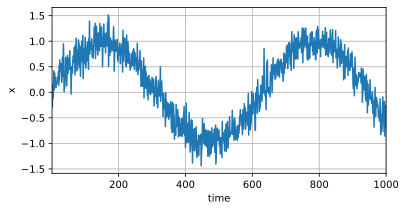

In [29]:
%matplotlib inline
import torch
from tqdm import tqdm
from torch import nn
from d2l import torch as d2l
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2,(T,))
d2l.plot(time,[x],'time', 'x', xlim=[1,1000], figsize=(6, 3))

基于嵌入维度$\tau$，将数据映射为数据对$y_{t}=x_{t}$和$X_{t}=[x_{t-\tau},...,x_{t-1}]$

In [20]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:,i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1,1))
batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),batch_size,is_train=True)

定义模型

In [26]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def get_net():
    net = nn.Sequential(nn.Linear(4,10),
                        nn.ReLU(),
                        nn.Linear(10,1))
    net.apply(init_weights)
    return net
# 平方损失，MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [38]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X,y in tqdm(train_iter,desc="Train"):
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
            # tqdm.set_postfix(epoch=epoch+1)
        print(f'epoch {epoch+1}, loss: {d2l.evaluate_loss(net,train_iter,loss):f}',end='')
net = get_net()
train(net, train_iter, loss, 5, 0.01)

Train: 100%|██████████████████████████| 38/38 [00:00<00:00, 912.31it/s]


epoch 1, loss: 0.116080

Train: 100%|█████████████████████████| 38/38 [00:00<00:00, 1792.66it/s]


epoch 2, loss: 0.066094

Train: 100%|█████████████████████████| 38/38 [00:00<00:00, 1766.22it/s]


epoch 3, loss: 0.059657

Train: 100%|█████████████████████████| 38/38 [00:00<00:00, 1771.83it/s]


epoch 4, loss: 0.055655

Train: 100%|█████████████████████████| 38/38 [00:00<00:00, 1825.80it/s]


epoch 5, loss: 0.054402

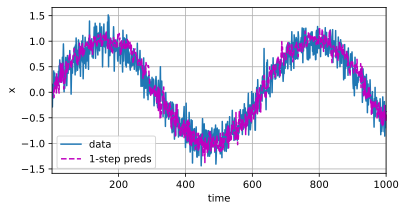

In [39]:
onestep_preds = net(features)
d2l.plot([time,time[tau:]],[x.detach().numpy(),onestep_preds.detach().numpy()],'time','x',legend=['data','1-step preds'],xlim=[1,1000],figsize=(6,3))

多步预测

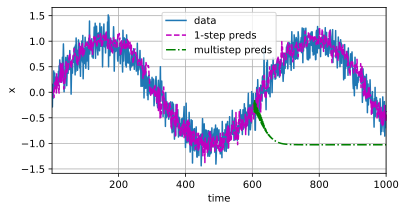

In [41]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1,-1)))
d2l.plot([time,time[tau:],time[n_train+tau:]],
         [x.detach().numpy(),onestep_preds.detach().numpy(),multistep_preds[n_train+tau:].detach().numpy()],
         'time','x',legend=['data','1-step preds','multistep preds'],xlim=[1,1000],figsize=(6,3))

In [ ]:
max_steps=64
features = torch.zeros((T-tau-max_steps+1,tau+max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))